In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from scipy import stats
%matplotlib inline

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

prices_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

Lots of categorical data to sift through, I will convert these to numerical values and then create plots to determine which categorical features should be included in the model.

# Split the data into categorical and continous variables

In [4]:
#Create series of continuous variable names, check that all continuous variables are numerical

cont_vars = pd.Series(['saleprice', 'yrsold', 'miscval', 'poolarea','screenporch', 'threessnporch', 'enclosedporch',
                             'wooddecksf', 'openporchsf','garagearea', 'garageyrblt', 'grlivarea', 'lowqualfinsf', 'firstflrsf', 
                             'secondflrsf','totalbsmtsf', 'bsmtunfsf', 'bsmtfinsf1', 'bsmtfinsf2', 'masvnrarea', 
                             'yearbuilt', 'yearremodadd','lotarea', 'lotfrontage'])

prices_df.loc[:,cont_vars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
saleprice        1460 non-null int64
yrsold           1460 non-null int64
miscval          1460 non-null int64
poolarea         1460 non-null int64
screenporch      1460 non-null int64
threessnporch    1460 non-null int64
enclosedporch    1460 non-null int64
wooddecksf       1460 non-null int64
openporchsf      1460 non-null int64
garagearea       1460 non-null int64
garageyrblt      1379 non-null float64
grlivarea        1460 non-null int64
lowqualfinsf     1460 non-null int64
firstflrsf       1460 non-null int64
secondflrsf      1460 non-null int64
totalbsmtsf      1460 non-null int64
bsmtunfsf        1460 non-null int64
bsmtfinsf1       1460 non-null int64
bsmtfinsf2       1460 non-null int64
masvnrarea       1452 non-null float64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
lotarea          1460 non-null int64
lotfrontage      1201 non-null float64

In [5]:
#Create series of the categorical variable names

cat_vars = []

for var in prices_df.columns:
    if cont_vars.str.contains(var).any() == False:
        cat_vars.append(var)

cat_vars = pd.Series(cat_vars)

In [6]:
#Check that no variables are in both variable lists

for var in prices_df.columns:
    if cont_vars.str.contains(var).any() & cat_vars.str.contains(var).any():
        print(var)

# Convert categorical variables to numerically coded categories

This will loop through the categorical variables, if the dtype is an object, it will create a dictionary of unique categories and an integer based on the order of appearance in the dataset, it will use this dictionary to replace the values of the coded_df variables with the assigned categorical integers. For future reference, all categories and their codes will be saved in a codebook dictionary object.

In [7]:
coded_df = prices_df.copy()
codebook = {}

for var in cat_vars:
    if  coded_df[var].dtype == 'O':
        
        #Create replace dict for each variable
        labels = coded_df[var].unique()
        replace_dict = {k: v for k,v in zip(labels,range(len(labels)))}
        
        #Add var entry to codebook and replace in dataframe
        codebook.update({var: replace_dict})
        coded_df.loc[:,var] = coded_df[var].replace(replace_dict) 

With the shear number of variables in the dataset, plotting all the data is unrealistic. As a preliminary measure, I will ensure that the Sale Price data is clean and then perform ANOVA's on the categorical data to determine which variables should be kept for modelling.

# Determining which categorical variables will be included in the model 

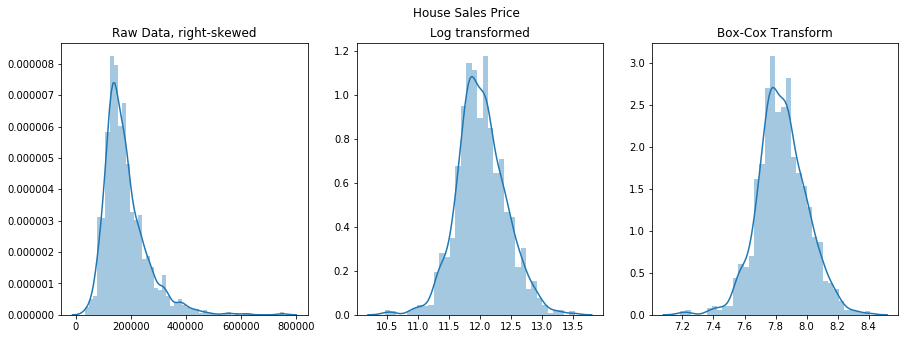

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.distplot(coded_df['saleprice'])
plt.title('Raw Data, right-skewed')
plt.xlabel('')

plt.subplot(1,3,2)
sns.distplot(np.log(coded_df['saleprice']))
plt.title('Log transformed')
plt.xlabel('')

plt.subplot(1,3,3)
sns.distplot(stats.boxcox(coded_df['saleprice'])[0])
plt.title('Box-Cox Transform')

plt.suptitle('House Sales Price')
plt.show()

In [9]:
stat, p = stats.normaltest(coded_df['saleprice'])
print('Normality test for Raw Data = ' + str(p))

stat, p = stats.normaltest(np.log(coded_df['saleprice']))
print('Normality test for Log Transformed Data = ' + str(p))

stat, p = stats.normaltest(stats.boxcox(coded_df['saleprice'])[0])
print('Normality test for Box-Cox Transformed Data = ' + str(p))

Normality test for Raw Data = 2.283848353787728e-133
Normality test for Log Transformed Data = 2.8921658220524008e-06
Normality test for Box-Cox Transformed Data = 4.420586560910238e-06


While none of these are normal, Box-Cox transformation resulted in the highest p-value for the D'Agnostino's K^2 Test. I will use this transformation for the ANOVA tests.

In [10]:
coded_df['boxcox_saleprice'] = stats.boxcox(coded_df['saleprice'])[0]

In [11]:
#Loop through cat_vars and conduct One-Way Anova across the groups in each cat_var for boxcox_saleprice

import statsmodels.api as sm
from statsmodels.formula.api import ols
F = []
p = []

for var in cat_vars:
    mod_str = 'boxcox_saleprice ~ ' + var
    mod = ols(mod_str, data=coded_df).fit()
    aov_table= sm.stats.anova_lm(mod, typ=2)
    F.append(aov_table['F'][0])
    p.append(aov_table['PR(>F)'][0])

In [12]:
#Save results of anova in df with variable names

aov_res = pd.DataFrame(cat_vars, columns=['var'])
aov_res['F'] = F
aov_res['p-value'] = p 
aov_res.sort_values(by='F', ascending=False, inplace=True)

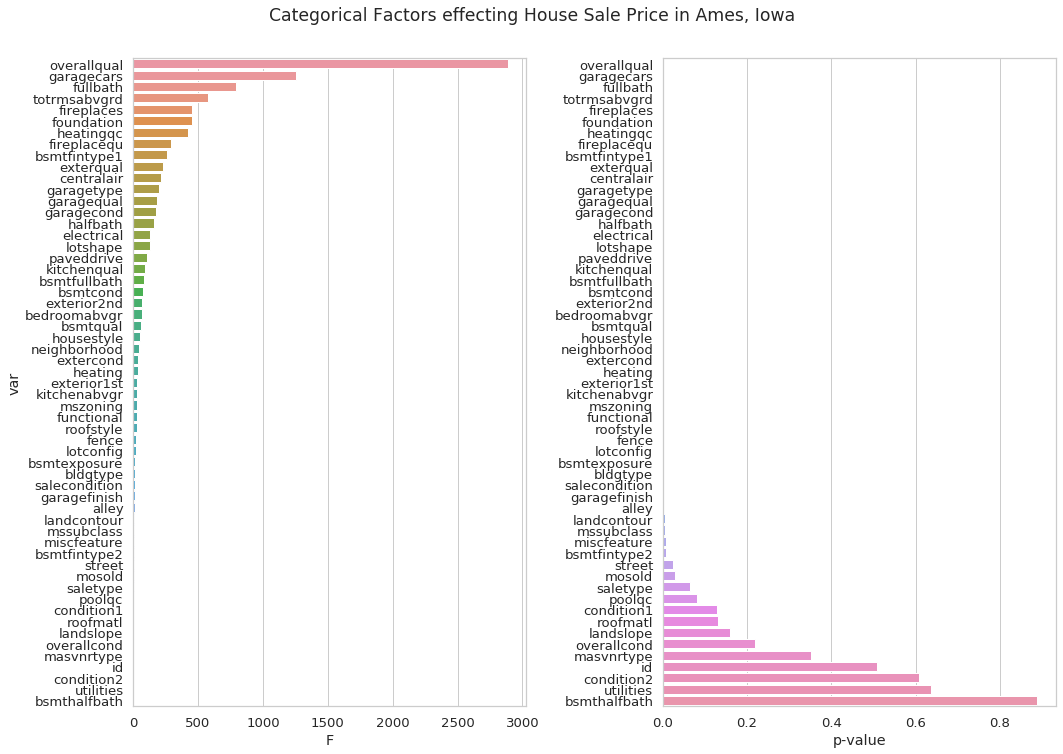

In [13]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.2, style='whitegrid')

plt.subplot(1,2,1)
sns.barplot(x='F', y='var', data=aov_res)

plt.subplot(1,2,2)
sns.barplot(x='p-value', y='var', data=aov_res)
plt.ylabel('')

plt.suptitle('Categorical Factors effecting House Sale Price in Ames, Iowa', y=1.05)
plt.tight_layout()
plt.show()

This plot illustrates which categorical factors have the greatest effect on housing prices. Variables with smaller F-statistics are more likely to have similar housing prices across the groups in that category. While most of these variables have significant differences (p < 0.05), I am only interested in the variables that will have the greatest effect in our model.

# Determining which continuous variables will be included in the model

In [14]:
cont_vars = list(cont_vars)
cont_vars.insert(0,'boxcox_saleprice')

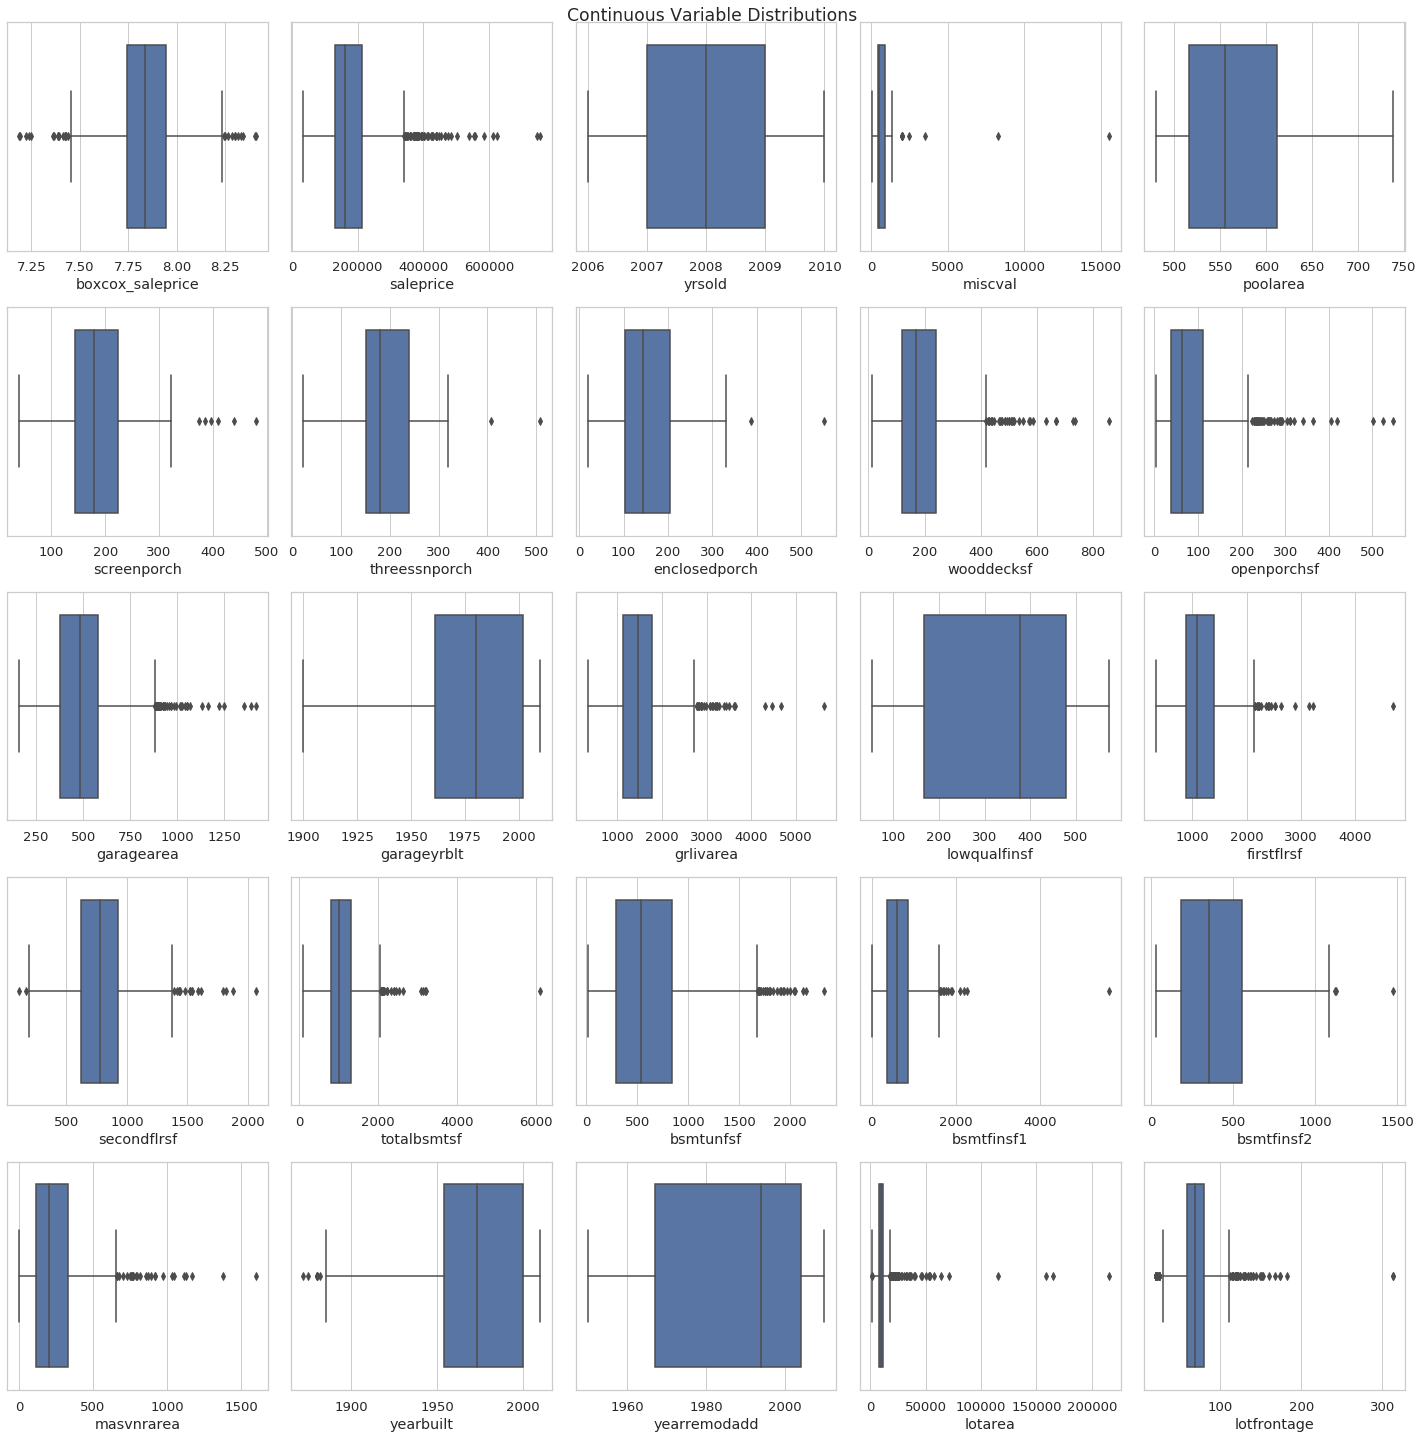

In [15]:
#Plot continuous data to see distributions, replace 0's with np.nan to avoid skewing data
nan_df = coded_df.copy()

fig, axes = plt.subplots(5, 5, figsize=(20,20))

for i in range(len(cont_vars)):
    nan_df.loc[:,cont_vars[i]] = nan_df[cont_vars[i]].replace(0,np.nan)
    sns.boxplot(nan_df[cont_vars[i]], ax=axes[int(np.floor(i/5)),i%5])
    
plt.suptitle('Continuous Variable Distributions', y=1)
plt.tight_layout()
plt.show()

While many of the variables have outliers, none of the values appear to be erroneous. To identify which variables should be included in the model, I will create a correlation matrix.

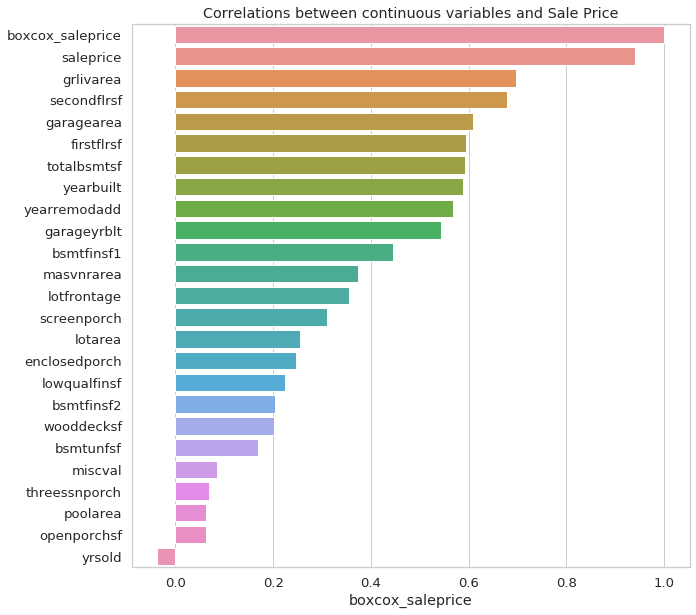

In [16]:
#Create correlation matrix, sort by saleprice
cont_corrs = nan_df[cont_vars].corr()
cont_corrs.sort_values(by='boxcox_saleprice',axis=0, ascending=False, inplace=True)

#Plot correlations for boxcox_saleprice 
plt.figure(figsize=(10,10))

sns.barplot(y=cont_corrs.index, x=cont_corrs.loc[:,'boxcox_saleprice'])
plt.title('Correlations between continuous variables and Sale Price')
plt.show()

Many correlations above; however, many of these variables have missing data (i.e. not all houses have a porch, pool, etc.). Therefore, if a significant amount of the data is null (>10%) for a continuous variable that we will include in the model (correlation > 0.5), I will convert it to a binary categorical variable.

In [17]:
#Print percentages of null values for continuous variables that have missing data

print('% Null for Continuous Variables with Null Values\n')
print(((nan_df.isnull().sum()/nan_df.isnull().count()*100)[nan_df.isnull().sum() > 0]))

% Null for Continuous Variables with Null Values

lotfrontage      17.739726
masvnrarea       59.520548
bsmtfinsf1       31.986301
bsmtfinsf2       88.561644
bsmtunfsf         8.082192
totalbsmtsf       2.534247
secondflrsf      56.780822
lowqualfinsf     98.219178
garageyrblt       5.547945
garagearea        5.547945
wooddecksf       52.123288
openporchsf      44.931507
enclosedporch    85.753425
threessnporch    98.356164
screenporch      92.054795
poolarea         99.520548
miscval          96.438356
dtype: float64


The only variable with a strong correlation (> 0.5) and a large number of null values (> 10%) is the secondflrsf variable. Therefore I will create a binary variable that categorizes houses with and without second floors.

In [18]:
nan_df['twostory'] = np.invert(nan_df['secondflrsf'].isnull())

In [19]:
#Add this new variable to anova results and compare the importance of this feature by its place in the list

twostory_test = stats.f_oneway(nan_df.loc[nan_df['twostory']==True,'boxcox_saleprice'], 
                               nan_df.loc[nan_df['twostory']==False,'boxcox_saleprice'])

In [20]:
aov_res = aov_res.append(pd.Series(['twostory', twostory_test[0], twostory_test[1]],index=aov_res.columns),
                         ignore_index=True)

aov_res.sort_values(by='F', ascending=False, inplace=True)
aov_res.index = range(len(aov_res))

In [21]:
print('The twostory variable is the {}th most important categorical variable'.format(aov_res[aov_res['var'] == 'twostory'].index[0]))

The twostory variable is the 28th most important categorical variable


Let's use the top 10 categorical variables and the continuous variables with >0.5 correlations to build our multiple linear regression model. 

In [22]:
#Create series of top 10 categorical variables
features = aov_res['var'][:10]

#Append series of continuous variables with greater than 0.5 correlation and remove saleprice vars and secondflrsf
cont_features = list(cont_corrs.loc[cont_corrs['boxcox_saleprice']>0.5, 'boxcox_saleprice'].index)
for var in ['boxcox_saleprice', 'saleprice','secondflrsf']: cont_features.remove(var)
    
features = features.append(pd.Series(cont_features), ignore_index=True)

Because some of the continuous variables have missing values (<6%, we need to impute data here before modeling). Because these null values represent values that did not have a certain feature (i.e. no garage), I will impute 0's.

In [23]:
coded_df.loc[:,features] = coded_df.loc[:,features].fillna(0)

In [24]:
print('Final independent features included in the model\n')
print(features)

Final independent features included in the model

0      overallqual
1       garagecars
2         fullbath
3     totrmsabvgrd
4       fireplaces
5       foundation
6        heatingqc
7      fireplacequ
8     bsmtfintype1
9        exterqual
10       grlivarea
11      garagearea
12      firstflrsf
13     totalbsmtsf
14       yearbuilt
15    yearremodadd
16     garageyrblt
dtype: object


In [28]:
#Sort data into dependent and independent variables
Y = coded_df['boxcox_saleprice']
X = coded_df[features]
X = sm.add_constant(X)


results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       boxcox_saleprice   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     422.2
Date:                Wed, 14 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:56:56   Log-Likelihood:                 1925.6
No. Observations:                1460   AIC:                            -3815.
Df Residuals:                    1442   BIC:                            -3720.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.6515      0.271     17.188      0.000       4.121       5.182
overallqual      0.0319      0.002     15.102      0.000       0.028       0.036
garagecars       0.0174      0.006      3.147      0.002       0.007       0.028
fullbath        -0.0020      0.005     -0.427      0.669      -0.011       0.007
totrmsabvgrd     0.0052      0.002      2.677      0.008       0.001       0.009
fireplaces       0.0275      0.004      6.561      0.000       0.019       0.036
foundation      -0.0069      0.003     -2.324      0.020      -0.013      -0.001
heatingqc       -0.0087      0.002     -3.910      0.000      -0.013      -0.004
fireplacequ      0.0016      0.002      0.688      0.492      -0.003       0.006
bsmtfintype1    -0.0031      0.001     -2.556      0.011      -0.005      -0.001
exterqual       -0.0029      0.004     -0.835      0.404      -0.010       0.004
grlivarea     6.735e-05   7.51e-06      8.967      0.000    5.26e-05    8.21e-05
garagearea    3.075e-05    1.8e-05      1.706      0.088    -4.6e-06    6.61e-05
firstflrsf    2.336e-05      9e-06      2.594      0.010     5.7e-06     4.1e-05
totalbsmtsf   2.788e-05    7.9e-06      3.530      0.000    1.24e-05    4.34e-05
yearbuilt        0.0006   9.57e-05      6.136      0.000       0.000       0.001
yearremodadd     0.0008      0.000      6.664      0.000       0.001       0.001
garageyrblt   1.774e-05   4.93e-06      3.598      0.000    8.07e-06    2.74e-05
==============================================================================
Omnibus:                      952.949   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34266.485
Skew:                          -2.501   Prob(JB):                         0.00
Kurtosis:                      26.201   Cond. No.                     6.46e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""